In [1]:
#!/bin/python 
import tensorflow as tf 

from keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
# from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Input, Flatten, Dropout, Activation, Lambda, RepeatVector, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.engine.topology import Layer
from keras.layers.wrappers import TimeDistributed
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
import keras.utils
from keras.optimizers import SGD
#from bnn.loss_equations import bayesian_categorical_crossentropy
from Datas import Initialize_data,ComputeAccuracy,category_names



Using TensorFlow backend.


In [62]:

# (trx,trY,trsy,valx,valY,valy,testx,testY,testy) = Initialize_data(1)      
# #### the dropout rate
# rate = 0.1
# #### build model

# model = Sequential()
# model.add(BatchNormalization())
# first_layer = model.add(Dense(500, input_shape=(3072,), activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(rate, noise_shape=None, seed=None))

# model.add(Dense(100, activation="relu",name = 'ab'))
# model.add(BatchNormalization())
# model.add(Dropout(rate, noise_shape=None, seed=None))

# x = model.add(Dense(10, activation="softmax"))



# #### model compile
# INIT_LR = 0.1
# opt = SGD(lr = INIT_LR)
# model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# EPOCHS = 10
# BATCH = 2000
# #### model fit

# H = model.fit(trx, trY, validation_data=(valx, valY),
#               epochs = EPOCHS, batch_size = BATCH)
# #### model predict

# predictions = model.predict(testx, batch_size = BATCH)
# print(H)

In [63]:

#### compute the accuracy in test data
def ComputeAccuracy(predictions,testY):
    answers = predictions.argmax(axis=1)
    (d, ) = np.shape(testY)
    ii = np.reshape(np.array(testY),(d,1))
    y = np.reshape(np.array(answers),(d,1))		
    correct = ii - y
    correct[correct!=0] = -1
    correct[correct==0] = 1
    correct[correct==-1] = 0
    a = np.count_nonzero(correct)
    result = float(a)/float(d)
    return result

def Draw_loss(epochs,predictions,H):
    N = np.arange(0, epochs)
    plt.style.use("ggplot")
    #### print accuracy
    plt.plot(N, H.history["acc"], label="train_acc")
    plt.plot(N, H.history["val_acc"], label="val_acc")
    plt.title(" Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    #### print loss
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.title("Training Loss ")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    
    
# Draw_loss(EPOCHS,predictions,H)  
# print('accuracy in test data')
# print(ComputeAccuracy(predictions,testy))

In [2]:
def Build_Model(full,Batch_size,Epoch):
    (trx,trY,trsy,valx,valY,valy,testx,testY,testy) = Initialize_data(full)  
    rate = 0.5
    Inputs = Input(shape=(3072,))
    x = BatchNormalization()(Inputs)
    x = Dense(500, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(rate,noise_shape=None, seed=None)(x)
    x = Dense(200, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(rate,noise_shape=None, seed=None)(x)
    # x = Dense(50, activation="relu")(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.5,noise_shape=None, seed=None)(x)
    out = Dense(10, activation='softmax')(x)
    model = Model(inputs = Inputs, outputs = out)

    INIT_LR = 0.1
    opt = SGD(lr = INIT_LR)
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=["accuracy"])

    #### model fit

    H = model.fit(trx, [trY,trY], validation_data=(valx, [valY,valY]),
                    epochs = Epoch, batch_size = Batch_size)
    #### model predict

    predictions = model.predict(testx, batch_size = Batch_size)

    #### print Accuracy 
    print('accuracy in test data')
    print(ComputeAccuracy(predictions,testy))
    #### Draw loss
    Draw_loss(Epoch,predictions,H)  
    #### calculate the uncertainty
    #### variance ratio for test data
    print("variance ratio:")
    print(variance_ratio(testy))
    #### Epistemic uncertainty
    print('Epistemic Uncertainty: predictive Entropy')
    print(predictive_uncertainty(predictions))
    print('Epistemic Uncertainty: Monte_carlo')
    (prediction_probabilities, prediction_variances) = montecarlo_prediction(predictions)
    print('prediction probabilities:')
    print(prediction_probabilities)
    print('predoction_variances:')
    print(prediction_variances)
    return predictions
    
full = 1
Batch_size =  2500
Epoch = 40
predictions = Build_Model(full,Batch_size,Epoch)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0....

#aleatoric uncertainty


-> Aleatoric uncertainty measures what you can't understand from the data
heteroscedastic here.
-> Aleatoric uncertainty is a function of the input data. the loss function creates a normal distribution with a mean of zero and the predicted variance. It distorts the predicted logit values by sampling from the distribution and computes the softmax categorical cross entropy using the distorted predictions. The loss function runs T Monte Carlo samples and then takes the average of the T samples as the loss.
-> noise on data 

In [28]:
def variance_ratio(trainy):
    T = len(trainy)
    trainy = np.array(trainy)
    ans = np.bincount(trainy).argmax()
    
    fx = len(trainy[np.where(trainy==ans)])
    
    ratio = 1- float(fx)/float(T)
    
    return ratio
#(trx,trY,trsy,valx,valY,valy,testx,testY,testy) = Initialize_data(full) 
print(variance_ratio(testy))




def cross_entropy(pred,true):
#     (D,h) = softmax_data.shape
#     print(np.sum(pred * np.log(pred), axis=1))
    return -np.sum(true * np.log(pred), axis=1)
def gaussian_distort(softmax_data,variance,std):
    import scipy.stats
    dist    = scipy.stats.norm(std,variance) 
    asx     = dist.pdf(softmax_data)
    #print(np.array(asx).shape)
    return np.array(asx)
def distored_lossfn(softmax_data,variance,std,D,trainY):
    temp_asx = np.zeros(softmax_data.shape)
    (D,c) = softmax_data.shape
    for i in range(D):
        temp_asx[i,:] = gaussian_distort(softmax_data[i,:],variance[i],std[i])
    softmax_data = softmax_data + temp_asx
        
#     std    = np.reshape(std,(D,1))
    
#     repstd = np.tile(std,(1,10))
#     foo    = softmax_data + std
#     repvar = np.tile(variance,(10,1))
#     foo    = foo*2/(2*(repvar.T**2))
    #foo    = 1/(np.sqrt(2*np.pi*(repvar.T**2))) * np.exp(-foo)
#     print(foo)
    return (softmax_data,temp_asx)
def variance_std (softmax_data):
    (D,h)              = softmax_data.shape
    variance           = np.var(softmax_data,axis=1)
    std                = np.sqrt(variance)  
    return (variance,std)
def bayesian_categorical_crossentropy_nodist(softmax_data,trainY):
    
    (D,h)              = softmax_data.shape
    (variance,std) = variance_std(softmax_data)
    variance_depressor = np.exp(variance) - np.ones_like(variance)
    alpha = 0.1
#     #### monte carlo results
    undistorted_loss              = cross_entropy(softmax_data,trainY)
    temp_asx = np.zeros(softmax_data.shape)
    softmax_temp = softmax_data
    for i in range(4):
        (variance,std) = variance_std(softmax_data)
        (softmax_temp,temp_asx)   = distored_lossfn(softmax_temp,variance,std,D,trainY)
        
                       
    temp_asx     /=4
    softmax_temp                  = softmax_data+temp_asx
    distorted_loss                = cross_entropy(softmax_temp,trainY)
    diff                          = undistorted_loss - distorted_loss
    
   
    mask1                         = diff
    mask1                         = np.array(mask1)
    diff                          = np.array(diff)
    mask1[mask1>0]                = 0
    mask1[mask1<=0]               = 1
    w                             = (np.exp(diff)-1)*alpha
    w                             = w * mask1
    diff[diff<0]                  = 0
    diff                          = -(diff + w)
    
    variance_loss = np.mean(diff, axis=0) * undistorted_loss
    
    loss = variance_loss + undistorted_loss + variance_depressor
    
    return loss

# loss = bayesian_categorical_crossentropy_nodist(predictions,testY)
# print(loss)
#### Epistemic uncertainty
def predictive_uncertainty(softmax_data):
    w = softmax_data * np.log(softmax_data)
    w = np.sum(w,axis = 1)
   
    return -w
# print('predictive')
# print(predictive_uncertainty(predictions))
def  montecarlo_prediction(predictions):
    prediction_probabilities = np.mean(predictions, axis=0)
    prediction_variances = predictive_uncertainty(predictions)
    print(prediction_variances)
    print(prediction_probabilities)
    return (prediction_probabilities, prediction_variances)

# print('epistemic')
# montecarlo_prediction(predictions)

0.9


#### epistemic uncertainty.
-> predictive entropy
-> Epistemic uncertainty measures what your model doesn't know due to lack of training data. It can be explained away with infinite training data. Think of epistemic uncertainty as model uncertainty.  this should decrease during training !! 

In [39]:
def predictive_entropy(pred):
    #### for each class
    return -1 * np.sum(np.log(pred) * pred, axis=0)
pred_entropy = predictive_entropy(predictions)

correct uncertainty:
3521.8506850600243
not correct uncertainty:
10302.442619264126
correct uncertainty each class:


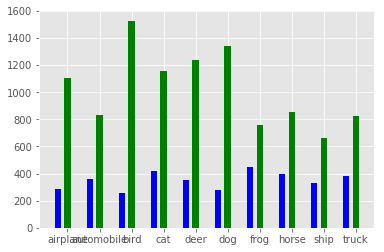

In [41]:
#### correct -> uncertainty large
loss = bayesian_categorical_crossentropy_nodist(predictions,testY)
answers = predictions.argmax(axis=1)
w = 0
k = 0
#### correct_class
corclass_uncertainty = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}
nocclass_uncertainty = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}
for i in range(10000):
    if answers[i] == testy[i]:
        corclass_uncertainty[str(testy[i])] +=loss[i]
#         print('correct:')
#         print(answers[i])
#         print(testy[i])
#         print(loss[i])
        w = w + loss[i]
    else:
#         print('not correct:')
#         print(answers[i])
#         print(testy[i])
#         print(loss[i])
        nocclass_uncertainty[str(testy[i])] += loss[i]
        k = k + loss[i]
#     print('------')
print('correct uncertainty:')
print(w)
print('not correct uncertainty:')
print(k)
print('correct uncertainty each class:')
import matplotlib.pyplot as plt
x  = corclass_uncertainty.values()
x1 = nocclass_uncertainty.values() 
y  =  np.arange(10)
name = category_names('cifar10')
w = 0.3
ax = plt.subplot(111)
ax.bar(y-w, x, width=0.2, color='b', align='center')
ax.bar(y,  x1,  width=0.2, color='g', align='center')
plt.xticks(y,name)
plt.show()

# for i in range(10):
#     print('class ',i,':')
#     print(corclass_uncertainty[str(i)])
# print('no correct uncertainty each class:')
# for i in range(10):
#     print('class ',i,':')
#     print(nocclass_uncertainty[str(i)])

#### Training a CNN - load data
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()



In [55]:
batch_size = 32 
num_classes = 10
epochs = 1600
data_augmentation = True
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [58]:
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalMaxPooling2D
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(48, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(48, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(80, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(80, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(80, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(80, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(80, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same',
                                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.25))

model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary ()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 48)        13872     
__________

In [60]:
opt = keras.optimizers.Adam(lr=0.0001)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
                            optimizer=opt,
                            metrics=['accuracy'])

print("train____________")
H = model.fit(x_train,y_train,epochs=600,batch_size=128,)
print("test_____________")
predictions = model.predict(x_test,batch_size = batch_size, )
# loss,acc = model.evaluate(X_test,y_test)
# print("loss=",loss)
# print("accuracy=",acc)

train____________


ValueError: Error when checking target: expected activation_22 to have 2 dimensions, but got array with shape (50000, 10, 10)